OBJECTIVE IS TO BUILD A TEXT CLASSIFICATION MODEL AND DEPLOY IT

In [1]:
import pandas as pd
import numpy as np

In [2]:
#text
import nltk
nltk.download("stopwords")
import string
import re
import json
from bs4 import BeautifulSoup

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\kiptanui\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
#Data Preprocessing & Markerting
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

In [4]:
#Machine Learning Libraries
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

In [5]:
#Importing evaluation metrics
from sklearn.metrics import log_loss, accuracy_score, f1_score, confusion_matrix, classification_report

In [6]:
#Deployment module
import streamlit as st
import pickle
import joblib
from joblib import dump

In [7]:
#Reading in the csv file
df = pd.read_csv('E:/data science/MODEL DEPLOYMENT/TAAC/taac_assistant_taac_4.csv')
df

,TaskId,User_Search_Term,Ad,Website,Relevance
0,1,wwww ncquickpass com,Nc Quick Pass - Pay Your Bill Online,www.doxo.com/pay/nc-quick-pass,Other
1,2,peloton plano tx,Studio Cycle Comparison - Find The Best Exerci...,www.nordictrack.com/Studio-Cycles/S22i,Other
2,3,antelope canyon,Hotels near Antelope Canyon - 100% Real Custom...,www.booking.com/Antelope-Canyon/Hotels,Other
3,4,get vaccine after covid,Janssen COVID-19 Vaccine - Authorized For Emer...,www.janssencovid19vaccine.com,Other
4,5,ahs.com/my-accountlogin,Find First american home warranty login - Chec...,www.searchandshopping.org/Your Search/Results,Other
...,...,...,...,...,...
378,379,how do i make my own website for free,How to Create a Free Website - Create a Free O...,www.top10.com/Website_Builder/Best_Free,Good
379,380,chevy,2022 chevrolet Clearance - Get a New Chevrolet...,deal.car.com/Chevrolet/Compare_Prices,Good
380,381,diet counselling,Best Nutrition counselors - Find a Nutritionist,thumbtack.com,Good
381,382,Education Technology Company,Smart Classroom Technology,www.verizon.com,Other


In [8]:
#We can transform the Relevance column into our target varable

mapping = {
    'Good' : 1,
    'Other' : 0,
}
df['Relevance'] = df['Relevance'].replace(mapping)
df.head(10)

,TaskId,User_Search_Term,Ad,Website,Relevance
0,1,wwww ncquickpass com,Nc Quick Pass - Pay Your Bill Online,www.doxo.com/pay/nc-quick-pass,0
1,2,peloton plano tx,Studio Cycle Comparison - Find The Best Exerci...,www.nordictrack.com/Studio-Cycles/S22i,0
2,3,antelope canyon,Hotels near Antelope Canyon - 100% Real Custom...,www.booking.com/Antelope-Canyon/Hotels,0
3,4,get vaccine after covid,Janssen COVID-19 Vaccine - Authorized For Emer...,www.janssencovid19vaccine.com,0
4,5,ahs.com/my-accountlogin,Find First american home warranty login - Chec...,www.searchandshopping.org/Your Search/Results,0
5,6,nike,Shop Womens Shops: Amazon - Amazon.com Officia...,www.amazon.com/apparel/womens-shops,1
6,7,cfl fixture,Flashlight Accessories,www.Grainfer.com/Flashlights,0
7,8,nationwide pet insurance,2021's Top 10 Pet Insurance - Buyer's Guide (N...,buyersguide.org/Pet-Insurance,1
8,9,nike,Nike Official Site - Just Do It - Shop The Lat...,www.nike.com,1
9,10,used cars,CarMax Used Cars - Visit carmax.com - Large Na...,www.carmax.com/cars,1


<AxesSubplot:>

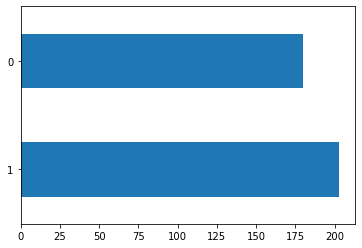

In [9]:
#Doing a visualization to check the overall distribution of the scores
df["Relevance"].value_counts().plot(kind = 'barh')

In [10]:
# Combine the three feature columns into one, separated by a space
df['Search_Term_Ad_Website'] = df['User_Search_Term'] + ' ' + df['Ad'] + ' ' + df['Website']

# Drop the individual feature columns if needed
df = df.drop(['User_Search_Term', 'Ad', 'Website'], axis=1)

# Now, 'combined_features' will contain the combined text from the three columns


2023-10-23 00:43:24.522 INFO    numexpr.utils: NumExpr defaulting to 8 threads.


In [11]:
#Reading in the combined features dataset
df.head(5)

,TaskId,Relevance,Search_Term_Ad_Website
0,1,0,wwww ncquickpass com Nc Quick Pass - Pay Your ...
1,2,0,peloton plano tx Studio Cycle Comparison - Fin...
2,3,0,antelope canyon Hotels near Antelope Canyon - ...
3,4,0,get vaccine after covid Janssen COVID-19 Vacci...
4,5,0,ahs.com/my-accountlogin Find First american ho...


In [12]:
new_df = df.drop(columns = ['TaskId'])
new_df.head()

,Relevance,Search_Term_Ad_Website
0,0,wwww ncquickpass com Nc Quick Pass - Pay Your ...
1,0,peloton plano tx Studio Cycle Comparison - Fin...
2,0,antelope canyon Hotels near Antelope Canyon - ...
3,0,get vaccine after covid Janssen COVID-19 Vacci...
4,0,ahs.com/my-accountlogin Find First american ho...


In [13]:
#We want to preprocess/clean this text first to remove things like punctuation symbols & ensure that our summary
#text is in lower case

space_replace = re.compile('[/(){}\[\]\|@,;)]')

In [14]:
#Replace all parts where we have punctuation marks with an empty space
bad_symbols = re.compile('[^0-9a-z #+_]')

In [15]:
stopwords = nltk.corpus.stopwords.words('english')

In [16]:
#remove url links from text
urls = re.compile('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|''[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+' 'rt')

In [17]:
def text_cleaning(text):
    text = BeautifulSoup(text, "lxml").text
    #Removing any html decoding <?>
    text = text.lower()
    text = space_replace.sub(' ', text)
    #replacing symbols with a space
    text = bad_symbols.sub('',text)
    #Deleting symbols from text
    text = ' '.join(word for word in text.split() if word not in stopwords)
    #Removing stopwords 
    text = urls.sub('', text) 
    return text

In [18]:
#applying our text cleaning function to our dataset
new_df['Search_Term_Ad_Website'] = new_df['Search_Term_Ad_Website'].apply(text_cleaning)
new_df.head()

,Relevance,Search_Term_Ad_Website
0,0,wwww ncquickpass com nc quick pass pay bill on...
1,0,peloton plano tx studio cycle comparison find ...
2,0,antelope canyon hotels near antelope canyon 10...
3,0,get vaccine covid janssen covid19 vaccine auth...
4,0,ahscom myaccountlogin find first american home...


In [19]:
#Now cleaning the text
def preprocessor(text):
    text = re.sub('<[^>]*>','', text)  #effectively removes html tags
    emoticons = re.findall('(?::|:|=)(?:-)?(?:\)|\(D|P)', text)
    text = re.sub('[\W]+','', text.lower() + ''.join(emoticons).replace('-',''))
    return text

In [20]:
#Split our data
x = new_df['Search_Term_Ad_Website']
y = new_df['Relevance']

In [21]:
#Splitting the data for training
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.3, random_state = 42)

In [22]:
y_train.head(2)

335    1
140    1
Name: Relevance, dtype: int64

DATA TRANSFORMATION

In [23]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics import accuracy_score, classification_report
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import cross_val_score

In [24]:
#Transforming  the text to vector (numerical form) then fed to our model

In [25]:
count_vect = CountVectorizer()
tfidf_vect = TfidfVectorizer()

In [26]:
#We now need to transform our x_train and y_train so they are transformed 
#from text data to vectors

In [27]:
#we will compare the performance of the 2 models

In [28]:
x_train_cv = count_vect.fit_transform(x_train)
x_test_cv = count_vect.transform(x_test)

In [29]:
x_train_tfidf = tfidf_vect.fit_transform(x_train)
x_test_tfidf = tfidf_vect.transform(x_train)

In [30]:
#For test, we use only transform
#For train, we use fit_transform

In [31]:
# Print the first few rows of x_train and y_train
print("x_train:", x_train.head())
print("y_train:", y_train.head())

x_train: 335    boiron homeopathic syphilis boiron homeopathic...
140       airpods ee apple airpods wireless sale ebaycom
132    google colaboratory google workspace streamlin...
253    find tickets plate number check license plate ...
153    owen sound dodge dealership 2022 dodge dealers...
Name: Search_Term_Ad_Website, dtype: object
y_train: 335    1
140    1
132    0
253    0
153    0
Name: Relevance, dtype: int64


In [32]:
y_train.head()

335    1
140    1
132    0
253    0
153    0
Name: Relevance, dtype: int64

In [33]:
x_train.head()

335    boiron homeopathic syphilis boiron homeopathic...
140       airpods ee apple airpods wireless sale ebaycom
132    google colaboratory google workspace streamlin...
253    find tickets plate number check license plate ...
153    owen sound dodge dealership 2022 dodge dealers...
Name: Search_Term_Ad_Website, dtype: object

In [34]:
#Shape of train data
y_train.shape

(268,)

In [35]:
#Shape of train data
x_train.shape

(268,)

In [36]:
x_train_cv.shape

(268, 1710)

In [37]:
x_train_tfidf.shape

(268, 1710)

MODELLING

In [38]:
multinomial_nb = MultinomialNB()
multinomial_nb.fit(x_train_cv, y_train)
predictions_cv = multinomial_nb.predict(x_test_cv)
score_cv = accuracy_score(predictions_cv, y_test)

In [39]:
score_cv

0.6869565217391305

In [40]:
y_pred = multinomial_nb.predict(x_test_cv)

In [41]:
confusion_matrix(y_test,y_pred)

array([[40, 19],
       [17, 39]], dtype=int64)

In [42]:
y_pred

array([0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0,
       1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1,
       0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0,
       1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1,
       1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1,
       0, 1, 1, 1, 0], dtype=int64)

In [43]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.70      0.68      0.69        59
           1       0.67      0.70      0.68        56

    accuracy                           0.69       115
   macro avg       0.69      0.69      0.69       115
weighted avg       0.69      0.69      0.69       115



In [57]:
def text_cleaning(text):
    # Your text cleaning code here
    text = BeautifulSoup(text, "lxml").text
    #Removing any html decoding <?>
    text = text.lower()
    text = space_replace.sub(' ', text)
    #replacing symbols with a space
    text = bad_symbols.sub('',text)
    #Deleting symbols from text
    text = ' '.join(word for word in text.split() if word not in stopwords)
    #Removing stopwords 
    text = urls.sub('', text)
    return text

def predict_label(model, count_vect, user_search_term, ad, website):
    # Combine the text data from the three columns into a single string
    combined_text = f"{user_search_term} {ad} {website}"

    # Clean the combined text
    cleaned_text = text_cleaning(combined_text)

    # Vectorize the text using the same vectorizer used during training
    text_features = count_vect.transform([cleaned_text])

    # Make a prediction using the trained model
    prediction = model.predict(text_features)

    # Return the predicted label
    return prediction

# Example usage:
col1_text = "1"
col2_text = "2"
col3_text = "5"

predicted_label = predict_label(multinomial_nb, count_vect, col1_text, col2_text, col3_text)
print(f"Predicted Label: {predicted_label}")


Predicted Label: [1]
